In [1]:
import sys
sys.path.append('../')

import gc
import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats

#from sa_decomp_layer import SADecompLayer



import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


#tf.__version__
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16, ResNet152, ResNet50

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp
from glob import glob


from tensorflow.keras.utils import to_categorical
from tensorflow.data import Dataset, AUTOTUNE
from imagenet_utils.imagenet_clsloc2 import clsloc
from imagenet_utils.load_images import load_images
from imagenet_utils.preprocess import preprocess

from utils.utils import *

import keras
from keras import layers

from keras import backend as K

import scienceplots

from activation_maximization import showall, getAM

plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

In [2]:
gc.collect()
model = VGG16(weights='imagenet',
				  include_top=True,
				  input_shape=(224, 224, 3))



In [3]:
LAYER =-1

In [4]:
top10KF = topKfilters(model, LAYER, k=20)   #Find the top 20% filters to look at
print(top10KF)

[70, 351, 268, 115, 13, 286, 476, 134, 484, 329, 435, 200, 144, 60, 145, 167, 364, 501, 66, 349, 141, 126, 370, 481, 473, 404, 158, 437, 29, 490, 247, 411, 348, 318, 310, 197, 213, 325, 92, 403, 1, 143, 90, 97, 366, 314, 478, 137, 459, 376, 44, 54, 410, 467, 299, 301, 377, 203, 357, 305, 38, 243, 446, 494, 400, 111, 322, 313, 140, 251, 135, 295, 139, 431, 426, 10, 208, 358, 317, 462, 353, 383, 396, 8, 198, 304, 190, 397, 355, 31, 64, 0, 185, 368, 6, 151, 122, 171, 37, 408, 466, 311]


In [5]:
conv_layers = []
for l in model.layers:
	if 'conv2d' in str(type(l)).lower():
		if l.kernel_size == (3,3):
			conv_layers.append(l)
			
layer_num = model.layers.index(conv_layers[LAYER])
layer_num_p = layer_num-1

In [ ]:
F = 385#top10KF[0]

In [7]:
origAM, scaledAM = getAM(model, LAYER, F )
modified_model = keras.models.Model(
	model.inputs, [model.layers[layer_num_p].output, model.layers[layer_num].output, model.output]
)

f2, f1, preds = modified_model(tf.expand_dims(origAM, axis=0), training=False)
f2_mean_act = tf.math.reduce_mean(f2, axis=(0,1,2))


block5_conv3


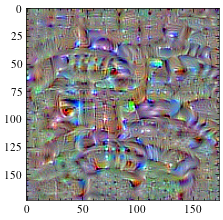

In [8]:

plt.imshow(tf.keras.utils.array_to_img(scaledAM))

In [9]:
def rotate (model_original, layers)  :
	model = tf.keras.models.clone_model(model_original)
	model.set_weights(model_original.get_weights())
	conv_layers = []
	for l in model.layers:
		if 'conv2d' in str(type(l)).lower():
			if l.kernel_size == (3,3) or l.kernel_size == (7,7):
				conv_layers.append(l)
				print(l)
	for l in layers:
		filters, biases = conv_layers[l].get_weights()
		print(conv_layers[l].name)
		# Reshape weights to (64 * 128, 3, 3) for batch processing
		k = filters.shape[0]
		weights_reshaped = tf.reshape(filters, (k, k,-1))

		rotated_weights = tf.image.rot90(weights_reshaped, k=2)
		rotated_weights = tf.reshape(rotated_weights, (k, k,filters.shape[-2],filters.shape[-1]))
		
		conv_layers[l].set_weights([rotated_weights, biases])


	return model


block5_conv3
block5_conv3


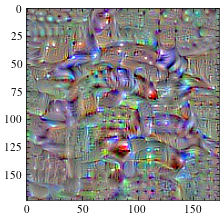

In [10]:
model_rot = rotate(model, [-1])
'''model_rot.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=False),            
			metrics=[
				keras.metrics.CategoricalAccuracy(name="accuracy"),
				keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),])'''

origAMR, scaledAMR = getAM(model_rot, LAYER, F )
modified_model = keras.models.Model(
	model_rot.inputs, [model_rot.layers[layer_num_p].output, model_rot.layers[layer_num].output, model_rot.output]
)

f2R, f1R, predsR = modified_model(tf.expand_dims(origAM, axis=0), training=False)
plt.imshow(tf.keras.utils.array_to_img(scaledAMR))

In [ ]:
filters = get_filter(model_rot, LAYER)  #[:,:,:, top10F.indices.numpy()]
filters = filters #/ np.sqrt(reduce_variance(filters, axis=None))
theta = getSobelTF(filters)
print(filters.shape)
s, a = getSymAntiSymTF(filters)
a_mag = reduce_euclidean_norm(a, axis=[0,1])
s_mag = reduce_euclidean_norm(s, axis=[0,1])

x =(a_mag[:,F]*np.cos((theta[:,F]))).numpy()
y = (a_mag[:,F]*np.sin((theta[:,F]))).numpy()
print(x.shape)
lim_x = np.max(np.abs(x))
lim_y = np.max(np.abs(y))
lim = np.max([lim_x, lim_y])
#lim =np.max(np.abs(mag[:, i]))    
lim*= 1.1
fig,ax  = plt.subplots(1,1,figsize=(10,3))
color =  matplotlib.colors.Normalize(vmin=0)(f2_mean_act)

ax.scatter(x,y, c=color, cmap = 'bwr', s=2)
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_box_aspect(1)

(3, 3, 512, 512)
(512,)


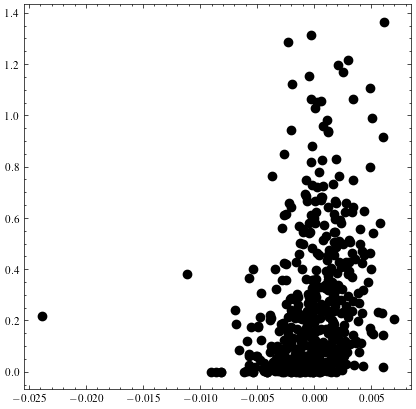

In [ ]:
domOrr = getDominantAngle(get_filter(model, LAYER)-1)
kernOrr = getSobelTF(filters)[:,F]
orrSim = domOrr - kernOrr  #orrientation similarity
orrSim  = np.arctan2(np.sin(orrSim), np.cos(orrSim))  #Wrap values -pi to pi
color =  matplotlib.colors.Normalize(vmin=-np.pi, vmax=np.pi)(orrSim)

fig,ax  = plt.subplots(1,1,figsize=(5,5))
dc = np.mean(filters, axis=(0,1))

ax.scatter(dc[:,F], f2_mean_act)


(-3.119755268096924, 3.1198949813842773)
-3.141592653589793
['-$\\pi$', '0', '$\\pi$']


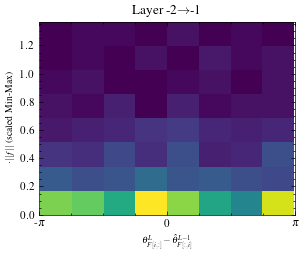

In [ ]:
fig, ax= plt.subplots(1,1)

data = orrSim
 # (np.array(cos_sim) + np.pi) % (2 * np.pi) - np.pi
ax.hist2d(data,f2_mean_act, bins=8)#, weights=weight)
print(ax.get_xlim())
data_min, data_max = np.min(data), np.max(data)

# Set the tick marks at intervals of π
tick_min = np.floor(data_min / np.pi) * np.pi  # Start at the lowest multiple of π
tick_max = np.ceil(data_max / np.pi) * np.pi    # End at the highest multiple of π
ticks = np.arange(tick_min, tick_max + np.pi, np.pi)  # Ticks spaced by π
print(tick_min)
# Format tick labels with π notation
labels = [f"{int(t / np.pi)}π" if t != 0 else "0" for t in ticks]
labels = [label.replace("π", "$\\pi$").replace("1$\\pi$", "$\\pi$") for label in labels]
print(labels)
# Set ticks and labels on the x-axis
ax.set_xticks(ticks=ticks, labels=labels)




#ax.convert_xunits(radians)
ax.set_ylabel(r"$\cdot ||f||$ (scaled Min-Max)", fontsize=7)
#ax.set_ylabel(r"Count", fontsize=7)
ax.set_xlabel(r"$\mathbf{\theta}^{L}_{F[i, :]} - \hat{\theta}^{L-1}_{F[:, i]}$", fontsize=7)
ax.set_title(f"Layer {LAYER-1}"+r"$\rightarrow$"+f"{LAYER}")


plt.show() 

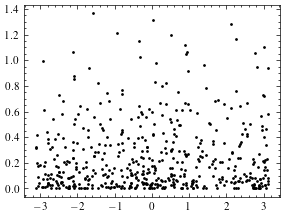

In [ ]:
fig, ax= plt.subplots(1,1)

ax.scatter(orrSim, f2_mean_act, s=1)

(3, 3, 512, 512)
(253,)


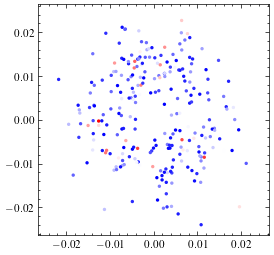

In [ ]:
posChannels = tf.where(tf.greater(np.sign(dc[:,F]),0))[:,0].numpy()
posChannels
filters = get_filter(model, LAYER)  #[:,:,:, top10F.indices.numpy()]
filters = filters #/ np.sqrt(reduce_variance(filters, axis=None))
theta = getSobelTF(filters)
print(filters.shape)
s, a = getSymAntiSymTF(filters)
a_mag = reduce_euclidean_norm(a, axis=[0,1])
s_mag = reduce_euclidean_norm(s, axis=[0,1])

x =(a_mag[:,F]*np.cos((theta[:,F]))).numpy()[posChannels]
y = (a_mag[:,F]*np.sin((theta[:,F]))).numpy()[posChannels]
print(x.shape)
lim_x = np.max(np.abs(x))
lim_y = np.max(np.abs(y))
lim = np.max([lim_x, lim_y])
#lim =np.max(np.abs(mag[:, i]))    
lim*= 1.1
fig,ax  = plt.subplots(1,1,figsize=(10,3))
color =  matplotlib.colors.Normalize(vmin=0)(f2_mean_act.numpy()[posChannels])

ax.scatter(x,y, c=color, cmap = 'bwr', s=2)
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_box_aspect(1)

(3, 3, 512, 512)
(512,)


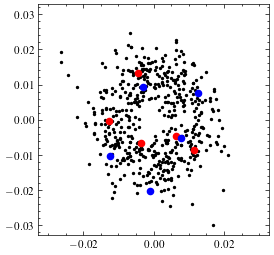

In [ ]:
negChannels = tf.where(tf.less(np.sign(dc[:,F]),0))[:,0].numpy()
negChannels
filters = get_filter(model, LAYER)  #[:,:,:, top10F.indices.numpy()]
filters = filters #/ np.sqrt(reduce_variance(filters, axis=None))
theta = getSobelTF(filters)
print(filters.shape)
s, a = getSymAntiSymTF(filters)
a_mag = reduce_euclidean_norm(a, axis=[0,1])
s_mag = reduce_euclidean_norm(s, axis=[0,1])

topAct = tf.argsort(f2_mean_act, direction='DESCENDING').numpy()#[:, top10F.indices.numpy()]
top10channels = topAct[np.isin( topAct, posChannels )]
top10channels = top10channels[:5]

x =(a_mag[:,F]*np.cos((theta[:,F]))).numpy()#[negChannels]
y = (a_mag[:,F]*np.sin((theta[:,F]))).numpy()#[negChannels]
print(x.shape)
lim_x = np.max(np.abs(x))
lim_y = np.max(np.abs(y))
lim = np.max([lim_x, lim_y])
#lim =np.max(np.abs(mag[:, i]))    
lim*= 1.1
fig,ax  = plt.subplots(1,1,figsize=(10,3))
color =  matplotlib.colors.Normalize(vmin=0)(f2_mean_act.numpy())



ax.scatter(x,y, c='black', cmap = 'bwr', s=2)
ax.scatter(x[top10channels],y[top10channels], c='red', cmap = 'bwr', s=20)
top10channels = topAct[np.isin( topAct, negChannels )]
top10channels = top10channels[:5]
ax.scatter(x[top10channels],y[top10channels], c='blue', cmap = 'bwr', s=20)

ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_box_aspect(1)

(array([34., 48., 37., 35., 38., 21., 16., 13.,  8.,  3.]),
 array([ 0.       ,  2.1296253,  4.2592506,  6.388876 ,  8.518501 ,
        10.648127 , 12.777752 , 14.907377 , 17.037003 , 19.166628 ,
        21.296253 ], dtype=float32),
 <BarContainer object of 10 artists>)

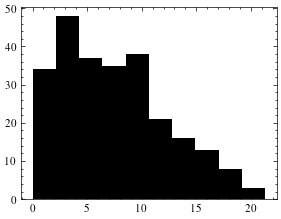

In [ ]:
plt.hist(tf.math.reduce_euclidean_norm(f2, axis=(0,1,2)).numpy()[posChannels])

(array([95., 56., 41., 19., 18., 13.,  8.,  4.,  1.,  4.]),
 array([ 0.       ,  2.1103303,  4.2206607,  6.3309913,  8.441321 ,
        10.551652 , 12.661983 , 14.772313 , 16.882643 , 18.992973 ,
        21.103304 ], dtype=float32),
 <BarContainer object of 10 artists>)

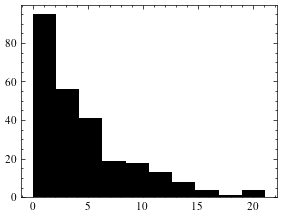

In [ ]:
plt.hist(tf.math.reduce_euclidean_norm(f2, axis=(0,1,2)).numpy()[negChannels])

In [ ]:
topAct = tf.argsort(f2_mean_act, direction='DESCENDING').numpy()#[:, top10F.indices.numpy()]
topAct[np.isin( topAct, posChannels )]

array([272, 150,  84, 484, 297, 333, 149, 317, 417, 100, 202, 413, 423,
       111, 350, 489, 394, 474, 495, 462, 396,   3, 328, 120, 457, 101,
       285, 375,  89, 239, 173, 164, 165, 354, 121, 126, 306,  68,  11,
       107, 447, 349, 205, 132, 216, 301, 501, 471,  40, 271,  25, 442,
       314, 496, 479, 379,  55, 227, 410,  52, 440, 367, 342, 282, 331,
        79, 130, 429, 155, 154, 364, 408, 201, 206, 289, 147, 222, 196,
       162, 119, 494, 280, 316, 184, 401, 186,  69, 491, 451, 112, 110,
        96, 290, 453, 357, 421, 198, 161, 211, 385, 141, 339, 323,  58,
       200, 181,  91, 265,  75, 221, 255, 118, 218, 113, 456, 378, 422,
       267,  48, 105, 492, 369, 477, 426, 172, 159, 321, 278,  99,  94,
       234, 320,  71, 247, 195, 386, 209, 312, 144, 393,  95,  12,  23,
        26,  29,  32,  37,  43,  45,  60,  76,  83,  87, 102, 104, 115,
       116, 125, 145, 153, 158, 169, 176, 183, 197, 208, 210, 214, 220,
       224, 228, 260, 261, 266, 279, 287, 291, 303, 304, 305, 30

In [ ]:
topAct[np.isin( topAct, negChannels )]

array([250, 439, 193, 199, 399,   7, 170, 203, 363, 293, 189,   1, 347,
       466, 368, 122, 296, 325, 230,  33,  82, 390,  35, 194, 254, 500,
       454, 308, 215,  98, 131, 463, 504, 407,   0, 286, 437, 503, 226,
       109, 372, 433, 373, 174,  27, 391, 427,  46, 241, 151, 472, 480,
       436, 167,  15, 345, 277, 344, 106, 431, 225,  57, 123, 376,   8,
       318,  74, 467, 490, 163, 424, 256, 510, 138, 133, 387, 473, 482,
       191, 140, 358,  72, 371, 182, 464, 486,  61, 283, 395,  77,  41,
       448,  31, 136, 178, 142, 322, 251, 415, 274, 166, 204,  63, 180,
       428, 192, 502, 292, 465, 352,  54, 398, 146, 434,  53, 157, 348,
       236, 263, 252, 335, 414, 377, 343,  44, 505, 117, 190, 294, 233,
        20, 240, 103, 315,  17, 435, 156, 409, 262,  80, 330,  70,  30,
        47,  64, 461,  51, 388, 243,  97, 245, 416,  88, 246, 128, 405,
       355, 276, 313, 370, 430, 244, 337,  50,  34, 253, 177,  13,  18,
       188, 402, 499, 231,  49, 129,  28,  59, 319, 498,  85, 14

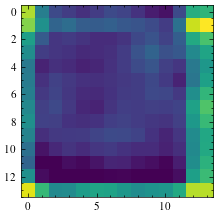

In [ ]:
plt.imshow(f2[0,..., 226])

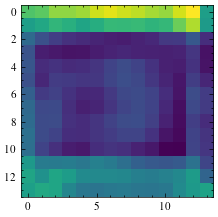

In [ ]:
plt.imshow(f2[0,..., 189])

(3, 3, 512, 512)
(512,)


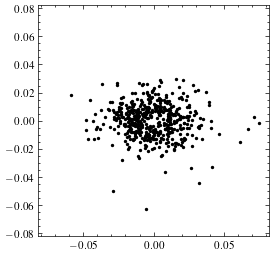

In [ ]:
F_p = topAct[np.isin( topAct, posChannels )][-1]
filters = get_filter(model, LAYER-1)  #[:,:,:, top10F.indices.numpy()]
filters = filters #/ np.sqrt(reduce_variance(filters, axis=None))
theta = getSobelTF(filters)
print(filters.shape)
s, a = getSymAntiSymTF(filters)
a_mag = reduce_euclidean_norm(a, axis=[0,1])
s_mag = reduce_euclidean_norm(s, axis=[0,1])

x =(a_mag[:,F_p]*np.cos((theta[:,F_p]))).numpy()
y = (a_mag[:,F_p]*np.sin((theta[:,F_p]))).numpy()
print(x.shape)
lim_x = np.max(np.abs(x))
lim_y = np.max(np.abs(y))
lim = np.max([lim_x, lim_y])
#lim =np.max(np.abs(mag[:, i]))    
lim*= 1.1
fig,ax  = plt.subplots(1,1,figsize=(10,3))

ax.scatter(x,y , s=2)
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_box_aspect(1)